In [11]:
from datetime import timedelta
import pandas as pd
import numpy as np
data = pd.read_csv("transitionTable.csv", encoding='utf-8')
data.head(10)

,Unnamed: 0,Utilisateur,Date,Heure,Action,Attribut,Delai
0,0,tdelille,2009-02-12,11:33:55,Connexion,login=tdelille,NaN
1,1,tdelille,2009-02-12,11:33:58,Afficher une structure (cours/forum),IDFORUM=7,NaN
2,2,mmay,2009-02-13,03:40:13,Répondre à un message,IDFORUM=7,00:09:46
3,3,mmay,2009-02-13,03:40:13,Répondre à un message,IDMSG=1184,00:09:46
4,4,mmay,2009-02-13,03:40:13,Répondre à un message,IDPARENT=1183,00:09:46
5,5,mmay,2009-02-13,03:30:13,Afficher le fil de discussion,IDFORUM=7,00:00:03
6,6,mmay,2009-02-13,03:30:13,Afficher le fil de discussion,IDMSG=1163,00:00:03
7,7,mmay,2009-02-13,03:27:50,Afficher le fil de discussion,IDFORUM=7,NaN
8,8,mmay,2009-02-13,03:27:50,Afficher le fil de discussion,IDMSG=1163,NaN
9,9,tdelille,2009-02-12,11:36:33,Afficher une structure (cours/forum),IDFORUM=10,NaN


# Indicateur 1: Déterminer les 3 meilleurs utilisateurs(sur une période donnée: jour, mois, année...)

In [12]:
def users():
    tab = []
    for u in data['Utilisateur']:
        if u not in tab:
            tab.append(u)
    return tab
users = users()

In [13]:
def nombreReponsesUser(utilisateur):
    cpt = 0
    for a in data[data['Utilisateur']==utilisateur]['Action']:
        if a == 'Répondre à un message':
            cpt += 1
    return cpt

def nombreReponses():
    tab = []
    for u in users:
        tab.append(nombreReponsesUser(u))
    return tab

In [14]:
def dureeAffichageMsgUser(utilisateur):
    dureeTot = 0
    for d in data[(data['Utilisateur']==utilisateur) & 
                       (data['Action']=='Afficher le contenu d\'\'un message') & 
                       (data['Attribut'].str[0:5]=="IDMSG")]['Delai']:
        if not pd.isnull(d):
            dureeTot += calDuree(d)
    return dureeTot

def dureeTotalAffichageMsg():
    tab = []
    for u in users:
        tab.append(dureeAffichageMsgUser(u))
    return tab

In [15]:
def calDuree(tps):
    return int(tps[0:2])*3600 + int(tps[3:5])*60 + int(tps[6:8])

In [16]:
print(calDuree("01:00:00"))

3600


In [17]:
def nombreDeMsgPosteUser(utilisateur):
    nb = 0
    for a in data[(data['Utilisateur']==utilisateur) & 
                       (data['Attribut'].str[0:5]=="IDMSG")]['Action']:
        if a == 'Poster un nouveau message':
            nb += 1
    return nb


def nombreDeMsgPoste():
    tab = []
    for u in users:
        tab.append(nombreDeMsgPosteUser(u))
    return tab

In [18]:
def nombreDeScrollbarUser(utilisateur):
    nb = 0
    for a in data[(data['Utilisateur']==utilisateur) & 
                       (data['Attribut'].str[0:5]=="IDMSG")]['Action']:
        if a == 'Bouger la scrollbar en bas':
            nb += 1
    return nb


def nombreDeScrollbar():
    tab = []
    for u in users:
        tab.append(nombreDeScrollbarUser(u))
    return tab

In [19]:
def pourcentage(tab):
    tot = 0
    t = []
    for e in tab:
        tot += e
    
    for e in tab:
        t.append((e/tot)*100)
    return t

In [20]:
pourcentageNbReponses = pourcentage(nombreReponses())
pourcentageTpsAffMsg = pourcentage(dureeTotalAffichageMsg())
pourcentageNbScrollbar = pourcentage(nombreDeScrollbar())
pourcentageNbMsgPoste = pourcentage(nombreDeMsgPoste())

In [21]:
def classementUtilisateurComplet(pourcentageNbReponses,pourcentageTpsAffMsg,pourcentageNbScrollbar,pourcentageNbMsgPoste):
    tab = []
    tot = sum(pourcentageNbReponses) + sum(pourcentageTpsAffMsg) + sum(pourcentageNbScrollbar) + sum(pourcentageNbMsgPoste)
    for i in range(0,len(users)):
        temp = pourcentageNbReponses[i] +  pourcentageTpsAffMsg[i] +  pourcentageNbScrollbar[i] +  pourcentageNbMsgPoste[i]
        tab.append((temp/tot)*100)
    return tab

classementComplet = classementUtilisateurComplet(pourcentageNbReponses,pourcentageTpsAffMsg,pourcentageNbScrollbar,pourcentageNbMsgPoste)


In [22]:
def classement3MeilleursUtilisateur(classementComplet):
    classementComplet2 = classementComplet.copy()
    tab = []
    for i in range(0,3):
        m = max(classementComplet2)
        mi = classementComplet2.index(m)
        tab.append((users[mi],m))
        classementComplet2[mi] = -1
    return tab

classement3MeilleursUtilisateur = classement3MeilleursUtilisateur(classementComplet)

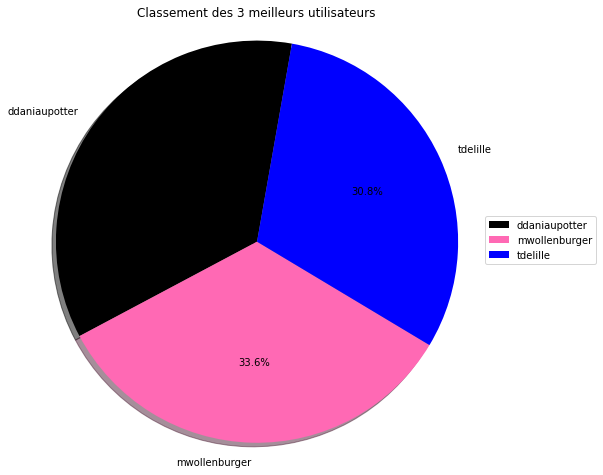

In [23]:
import matplotlib.pyplot as plt
labels2=[]
pourcentage2=[]
for (l,p) in classement3MeilleursUtilisateur:
    labels2.append(l)
    pourcentage2.append(p)

colors = ["black", "hotpink", "b", "#4CAF50"]
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))


plt.pie(pourcentage2, labels=labels2, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=80)

plt.axis('equal')
ax.set_title("Classement des 3 meilleurs utilisateurs")
plt.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig('classement3MeilleursUser.png')
plt.show()

# Indicateur 2: trouver les utilisateurs avec qui un utilisateur interagit le plus

In [24]:
def PourcentageInteractionUsers(data,Utilisateur, DateDebut, DateFin):
    ListIdParent=[]
    ListUserParent=[]
    ListInteractions=[]
    
    for elem in data[data['Utilisateur']==Utilisateur]['Attribut']:
        if elem[0:8]=="IDPARENT":
            ListIdParent.append(elem[9:])
   
    for idParent in ListIdParent:
        idParent="IDPARENT="+idParent
        for d in data['Date'].unique().tolist():
            if ((d >= DateDebut) and (d <= DateFin)):  
                for user in data[(data['Date'] == d) & (data['Attribut']==idParent) & (data['Action']=='Répondre à un message')]['Utilisateur'].tolist():
                    ListUserParent.append(user)

           
    while Utilisateur in ListUserParent:
        ListUserParent.remove(Utilisateur)

    total_Users=len(ListUserParent)
    
    for user in dict.fromkeys(ListUserParent):   
        ListInteractions.append((user,(ListUserParent.count(user)/total_Users)*100))

    return ListInteractions


In [25]:
# affichage de la liste des personnes ayant interagi avec tdelille pendant un jour (du 16 fevrier au 17 fevrier) avec leur pourcentage
print(PourcentageInteractionUsers(data, "tdelille", "2009-02-16", "2009-02-17"))

[('tsoubrie', 25.0), ('ddaniaupotter', 50.0), ('mmay', 12.5), ('gachort', 12.5)]


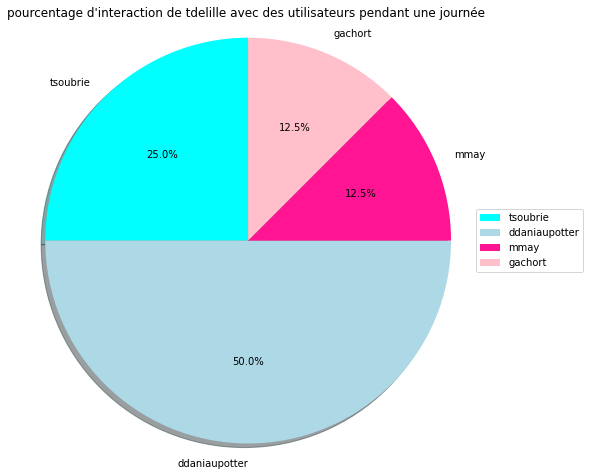

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
labels=[]
pourcentage=[]
for (l,p) in PourcentageInteractionUsers(data, "tdelille", "2009-02-16", "2009-02-17"):
    labels.append(l)
    pourcentage.append(p)

colors = ['cyan', 'lightblue', 'deeppink', 'pink','violet', 'lavender']
fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))


plt.pie(pourcentage, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
ax.set_title("pourcentage d'interaction de tdelille avec des utilisateurs pendant une journée ")

plt.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig('interaction_tdelille.png')
plt.show()

In [16]:
# affichage de la liste des personnes ayant interagi avec mwollenburger pendant un mois (du 1 fevrier au 28 fevrier) avec leur pourcentage
print(PourcentageInteractionUsers(data, "tdelille", "2009-02-01", "2009-02-28"))

[('gachort', 27.586206896551722), ('mmay', 10.344827586206897), ('tsoubrie', 13.793103448275861), ('mwollenburger', 13.793103448275861), ('ddaniaupotter', 34.48275862068966)]


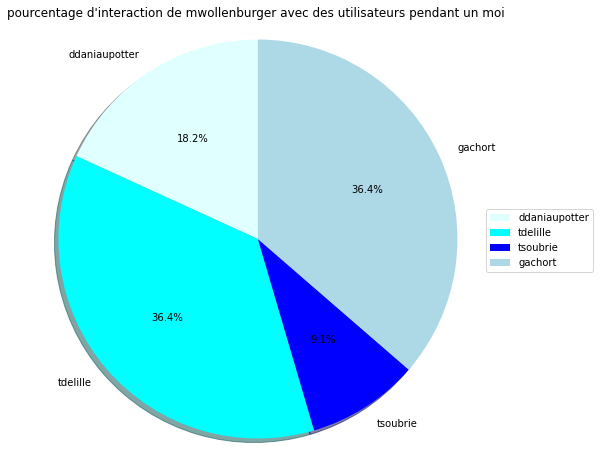

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
labels=[]
pourcentage=[]
for (l,p) in PourcentageInteractionUsers(data, "mwollenburger", "2009-02-01", "2009-02-28"):
    labels.append(l)
    pourcentage.append(p)


colors = ['lightcyan',  'cyan', 'blue', 'lightblue', 'royalblue','darkblue' ]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(aspect="equal"))


plt.pie(pourcentage, labels=labels, colors=colors, 
        autopct='%1.1f%%', shadow=True, startangle=90)

plt.axis('equal')
ax.set_title("pourcentage d'interaction de mwollenburger avec des utilisateurs pendant un moi ")
plt.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
plt.savefig('interaction_mwollenburger.png')
plt.show()